# Imports

In [54]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 3000)
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as stats



In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import metrics

# Read CSV

In [56]:
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [57]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [58]:
df.shape

(7043, 21)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

# Data cleaning

In [60]:
# changing the case of the col names
df.rename(str.lower,axis=1,inplace=True)

In [61]:
df.drop('customerid',axis=1,inplace=True)

In [62]:
df['totalcharges']=pd.to_numeric(df.totalcharges,errors='coerce')

In [63]:
df.isnull().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [64]:
df.dropna(inplace=True)

# EDA

Text(0.5, 1.0, 'Number Of Churn')

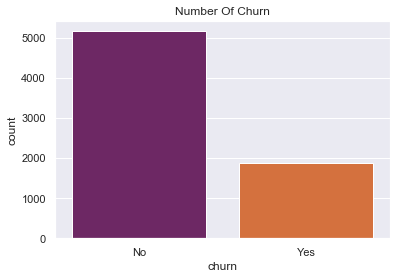

In [65]:
sns.set(style='darkgrid')
sns.countplot(df['churn'],palette='inferno').set_title('Number Of Churn')

Text(0.5, 1.0, 'Churn In Seniorcitizen')

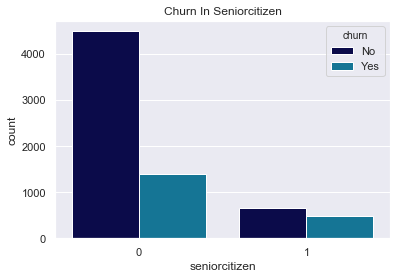

In [70]:
sns.set(style='darkgrid')
sns.countplot(df.seniorcitizen, hue = df.churn,palette='ocean' ).set_title('Churn In Seniorcitizen')

Text(0.5, 1.0, 'Churn By Contract')

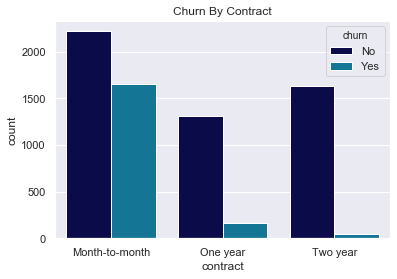

In [67]:
sns.set(style='darkgrid')
sns.countplot(df.contract, hue = df.churn,palette='ocean' ).set_title('Churn By Contract')

Text(0.5, 1.0, 'Churn By Tenure')

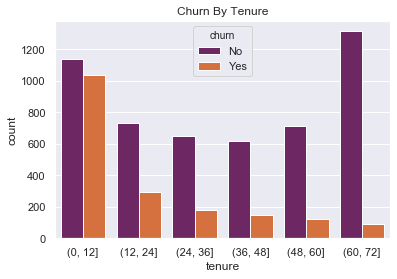

In [73]:
sns.set(style='darkgrid')
sns.countplot(bins_tenure, hue = df.churn,palette='inferno' ).set_title('Churn By Tenure')

Text(0.5, 1.0, 'Churn By Onlinesecurity')

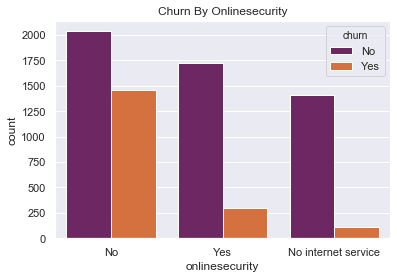

In [69]:
sns.set(style='darkgrid')
sns.countplot(df.onlinesecurity, hue = df.churn,palette='inferno' ).set_title('Churn By Onlinesecurity')

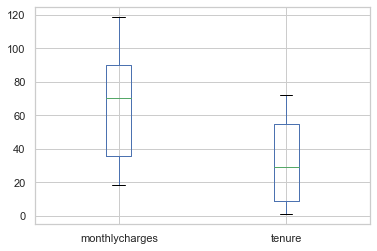

In [12]:
# checking outliers
df.boxplot(['monthlycharges','tenure'])

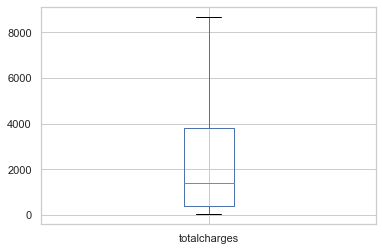

In [13]:
df.boxplot(['totalcharges'])

# Feature engineering

In [36]:
df['churn'].value_counts()

No     5163
Yes    1869
Name: churn, dtype: int64

In [37]:
df['churn'].isna().sum()

0

In [38]:
df['gender']=df['gender'].map({'Male':1,'Female':0})

In [39]:
two_hot_cols = ['phoneservice','partner','dependents','paperlessbilling','churn']
for i in two_hot_cols:
    df[i]=df[i].map({'Yes':1,'No':0})

In [40]:
three_hot_cols=['onlinesecurity','onlinebackup','deviceprotection','techsupport',
'streamingtv','streamingmovies']
# -no internet service,
for i in three_hot_cols:
    df[i]=df[i].map({'Yes':1,'No':0,'No internet service':2})

In [41]:
df['multiplelines']= df['multiplelines'].map({'Yes':1,'No':0,'No phone service':2})


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
gender              7032 non-null int64
seniorcitizen       7032 non-null int64
partner             7032 non-null int64
dependents          7032 non-null int64
tenure              7032 non-null int64
phoneservice        7032 non-null int64
multiplelines       7032 non-null int64
internetservice     7032 non-null object
onlinesecurity      7032 non-null int64
onlinebackup        7032 non-null int64
deviceprotection    7032 non-null int64
techsupport         7032 non-null int64
streamingtv         7032 non-null int64
streamingmovies     7032 non-null int64
contract            7032 non-null object
paperlessbilling    7032 non-null int64
paymentmethod       7032 non-null object
monthlycharges      7032 non-null float64
totalcharges        7032 non-null float64
churn               7032 non-null int64
dtypes: float64(2), int64(15), object(3)
memory usage: 1.4+ MB


In [43]:
dumm_col=['contract','paymentmethod','internetservice']

In [44]:
dumm_1=pd.get_dummies(df['contract'],prefix='contract',drop_first=True)

In [45]:
dumm_2=pd.get_dummies(df['paymentmethod'],prefix='pmt_mtd',drop_first=True)

In [46]:
dumm_3=pd.get_dummies(df['internetservice'],prefix='int_ser',drop_first=True)


In [47]:
bins=[0,12,24,36,48,60,72]
bins_tenure=pd.cut(df['tenure'],bins)

In [48]:
bins_tenure = bins_tenure.cat.as_ordered()

In [27]:
tenure_dummy=pd.get_dummies(bins_tenure,drop_first=True,prefix="tenure")

In [28]:
df2=pd.concat([df,dumm_1,dumm_2,dumm_3,tenure_dummy],axis=1)

In [29]:
df2.drop(columns=['tenure','contract','paymentmethod','internetservice'],axis=1,inplace=True)

In [30]:
df2.rename(columns={'tenure_(12, 24]':'tenure_1_2','tenure_(24, 36]':'tenure_2_3',
                    'tenure_(36, 48]':'tenure_3_4','tenure_(48, 60]':'tenure_4_5',
                    'tenure_(60, 72]':'tenure_5_6' },inplace=True)

In [31]:
df2.corr()

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,paperlessbilling,monthlycharges,totalcharges,churn,contract_One year,contract_Two year,pmt_mtd_Credit card (automatic),pmt_mtd_Electronic check,pmt_mtd_Mailed check,int_ser_Fiber optic,int_ser_No,tenure_1_2,tenure_2_3,tenure_3_4,tenure_4_5,tenure_5_6
gender,1.000000,-0.001819,-0.001379,0.010349,-0.007515,0.000084,-0.004365,-0.002978,0.004526,0.000057,0.000578,-0.001339,-0.011902,-0.013779,0.000048,-0.008545,0.007755,-0.003603,0.001632,0.000844,0.013199,-0.011189,0.004745,-0.000649,0.006249,-0.020658,-0.004319,0.016279
seniorcitizen,-0.001819,1.000000,0.016957,-0.210550,0.008392,0.100120,-0.210546,-0.152380,-0.156700,-0.223438,-0.129721,-0.120658,0.156258,0.219874,0.102411,0.150541,-0.046491,-0.116205,-0.024359,0.171322,-0.152987,0.254923,-0.182519,0.001860,0.027317,-0.000929,0.014186,-0.002407
partner,-0.001379,0.016957,1.000000,0.452269,0.018397,0.090774,0.081078,0.086346,0.093391,0.068277,0.079066,0.075310,-0.013957,0.097825,0.319072,-0.149982,0.083067,0.247334,0.082327,-0.083207,-0.096948,0.001235,-0.000286,-0.048481,0.003131,0.035092,0.105341,0.280353
dependents,0.010349,-0.210550,0.452269,1.000000,-0.001078,-0.017333,0.188889,0.160845,0.154819,0.179176,0.138809,0.125086,-0.110131,-0.112343,0.064653,-0.163128,0.069222,0.201699,0.061134,-0.149274,0.056448,-0.164101,0.138383,-0.001459,0.009289,0.023544,0.031419,0.118090
phoneservice,-0.007515,0.008392,0.018397,-0.001078,1.000000,-0.690813,0.125544,0.149932,0.138938,0.123533,0.171773,0.164379,0.016696,0.248033,0.113008,0.011691,-0.003142,0.004442,-0.006916,0.002747,-0.004463,0.290183,0.171817,0.012307,-0.000812,-0.019061,-0.009750,0.020516
multiplelines,0.000084,0.100120,0.090774,-0.017333,-0.690813,1.000000,-0.235077,-0.210051,-0.200400,-0.232474,-0.202326,-0.194858,0.108261,0.146127,0.251357,0.019609,0.000125,0.076285,0.051657,0.060466,-0.167426,0.014388,-0.313600,-0.044937,0.004059,0.037753,0.065824,0.175736
onlinesecurity,-0.004365,-0.210546,0.081078,0.188889,0.125544,-0.235077,1.000000,0.751312,0.748684,0.790951,0.701526,0.704672,-0.333656,-0.620532,-0.153234,-0.332443,0.096480,0.333667,0.067483,-0.357910,0.285061,-0.498691,0.844655,-0.013722,-0.020502,0.018513,0.019851,0.124319
onlinebackup,-0.002978,-0.152380,0.086346,0.160845,0.149932,-0.210051,0.751312,1.000000,0.740244,0.753752,0.720277,0.716388,-0.261565,-0.537727,-0.085017,-0.291047,0.091648,0.298196,0.057233,-0.301330,0.231894,-0.391371,0.825244,-0.033063,-0.015616,0.026342,0.039270,0.144597
deviceprotection,0.004526,-0.156700,0.093391,0.154819,0.138938,-0.200400,0.748684,0.740244,1.000000,0.767659,0.762742,0.766635,-0.275519,-0.512604,-0.077394,-0.281048,0.103041,0.330874,0.069858,-0.302989,0.223777,-0.384908,0.825541,-0.028895,-0.011747,0.040292,0.025581,0.142431
techsupport,0.000057,-0.223438,0.068277,0.179176,0.123533,-0.232474,0.790951,0.753752,0.767659,1.000000,0.737211,0.737126,-0.310354,-0.596805,-0.141011,-0.329474,0.094300,0.362562,0.068693,-0.360021,0.282558,-0.493550,0.843355,-0.023186,-0.007221,0.015828,0.014918,0.126260


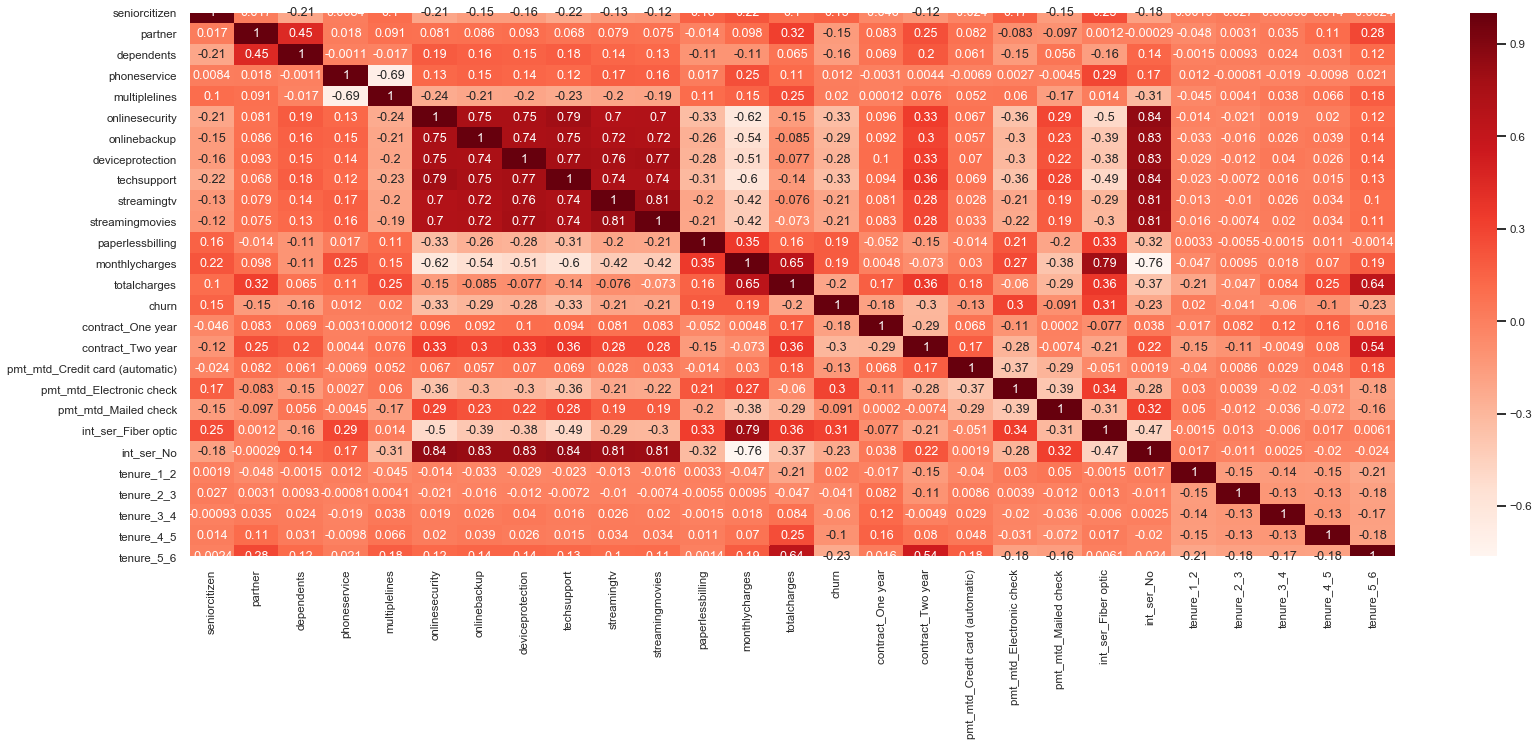

In [32]:
sns.set(rc={'figure.figsize':(27,10)})
sns.set_context("talk", font_scale=0.7)
    
sns.heatmap(df2.iloc[:,1:].corr(), cmap='Reds', annot=True);

In [33]:
df2.drop(columns=['streamingtv','streamingmovies','techsupport',
                  'deviceprotection','onlinebackup'],inplace=True)

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 23 columns):
gender                             7032 non-null int64
seniorcitizen                      7032 non-null int64
partner                            7032 non-null int64
dependents                         7032 non-null int64
phoneservice                       7032 non-null int64
multiplelines                      7032 non-null int64
onlinesecurity                     7032 non-null int64
paperlessbilling                   7032 non-null int64
monthlycharges                     7032 non-null float64
totalcharges                       7032 non-null float64
churn                              7032 non-null int64
contract_One year                  7032 non-null uint8
contract_Two year                  7032 non-null uint8
pmt_mtd_Credit card (automatic)    7032 non-null uint8
pmt_mtd_Electronic check           7032 non-null uint8
pmt_mtd_Mailed check               7032 non-null uint8
int_ser_F

# Models

## KNN

In [35]:
target=df2['churn']
features=df2.drop(columns=['churn'])

In [36]:
knn = KNeighborsClassifier(n_neighbors=1)
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.2,random_state=1)

In [37]:
# scaling

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [38]:
for i in range(12):
    knn = KNeighborsClassifier(n_neighbors=i+1)
    knn.fit(X_train,y_train.astype(int))
    y_pred= knn.predict(X_test)
    print("i= ",i+1,'Accuracy:' + str(metrics.accuracy_score(y_test.astype(int), y_pred)))
    print("i= ",i+1,'f1_score:' + str(metrics.f1_score(y_test.astype(int), y_pred)))
    print("-"*50)

i=  1 Accuracy:0.7327647476901208
i=  1 f1_score:0.4891304347826087
--------------------------------------------------
i=  2 Accuracy:0.7626154939587776
i=  2 f1_score:0.39051094890510946
--------------------------------------------------
i=  3 Accuracy:0.775408670931059
i=  3 f1_score:0.5574229691876751
--------------------------------------------------
i=  4 Accuracy:0.783226723525231
i=  4 f1_score:0.48217317487266553
--------------------------------------------------
i=  5 Accuracy:0.7775408670931059
i=  5 f1_score:0.5522174535050072
--------------------------------------------------
i=  6 Accuracy:0.7732764747690121
i=  6 f1_score:0.4692179700499168
--------------------------------------------------
i=  7 Accuracy:0.7818052594171997
i=  7 f1_score:0.5505124450951684
--------------------------------------------------
i=  8 Accuracy:0.7874911158493249
i=  8 f1_score:0.5200642054574639
--------------------------------------------------
i=  9 Accuracy:0.7761194029850746
i=  9 f1_score

## Logistic regression

### recursive feature logistic regression

In [55]:
df3 = df2.copy(deep=True)

In [56]:
#df2.columns

In [57]:
df3.columns=['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice',
       'multiplelines', 'onlinesecurity', 'paperlessbilling', 'monthlycharges',
       'totalcharges', 'churn', 'contract_1year', 'contract_2year',
       'pmt_mtd_creditcard', 'pmt_mtd_electronic_check',
       'pmt_mtd_mailed_check', 'int_ser_fiber_optic', 'int_ser_No',
       'tenure_1_2', 'tenure_2_3', 'tenure_3_4', 'tenure_4_5', 'tenure_5_6']

In [58]:
df3['churn'].isna().sum()

0

In [59]:
target=df3['churn']
features_all=df3.drop(columns=['churn'])

In [60]:
scaler = StandardScaler()
features_all_std = scaler.fit_transform(features_all)
logreg = LogisticRegression(C=1e9)
selector = RFE(logreg, n_features_to_select=1)
selector_all = selector.fit(features_all_std, target.astype(int))

In [61]:
selector_all.ranking_

array([20, 16, 21, 18, 17, 12,  2, 15, 10, 11,  3,  1, 19, 14, 22,  4, 13,
        9,  7,  8,  6,  5])

In [62]:
list(zip(features_all.columns,selector_all.ranking_))

[('gender', 20),
 ('seniorcitizen', 16),
 ('partner', 21),
 ('dependents', 18),
 ('phoneservice', 17),
 ('multiplelines', 12),
 ('onlinesecurity', 2),
 ('paperlessbilling', 15),
 ('monthlycharges', 10),
 ('totalcharges', 11),
 ('contract_1year', 3),
 ('contract_2year', 1),
 ('pmt_mtd_creditcard', 19),
 ('pmt_mtd_electronic_check', 14),
 ('pmt_mtd_mailed_check', 22),
 ('int_ser_fiber_optic', 4),
 ('int_ser_No', 13),
 ('tenure_1_2', 9),
 ('tenure_2_3', 7),
 ('tenure_3_4', 8),
 ('tenure_4_5', 6),
 ('tenure_5_6', 5)]

In [63]:
target=df3['churn']
features1=df3[['contract_1year','contract_2year','onlinesecurity',
              'tenure_1_2','tenure_2_3','tenure_3_4','tenure_4_5',
              'tenure_5_6']]

In [64]:
target.isna().sum()

0

In [65]:
scaler = StandardScaler()
features1_std = scaler.fit_transform(features1)
logreg = LogisticRegression(C=1e9)
selector1 = RFE(logreg, n_features_to_select=1)
selector1 = selector1.fit(features1_std, target.astype(int))

In [66]:
selector1.ranking_

array([3, 1, 2, 8, 5, 7, 6, 4])

In [67]:
list(zip(features1.columns,selector1.ranking_))

[('contract_1year', 3),
 ('contract_2year', 1),
 ('onlinesecurity', 2),
 ('tenure_1_2', 8),
 ('tenure_2_3', 5),
 ('tenure_3_4', 7),
 ('tenure_4_5', 6),
 ('tenure_5_6', 4)]

In [68]:
target=df3['churn']
features2 = df3[['contract_1year','contract_2year','monthlycharges',
        'gender','tenure_1_2','tenure_2_3','tenure_3_4','tenure_4_5',
        'tenure_5_6']]

In [69]:
scaler = StandardScaler()
features2_std = scaler.fit_transform(features2)
logreg = LogisticRegression(C=1e9)
selector2 = RFE(logreg, n_features_to_select=1)
selector2 = selector2.fit(features2_std, target.astype(int))

In [70]:
selector2.ranking_

array([2, 1, 3, 9, 8, 6, 7, 5, 4])

In [71]:
list(zip(features2.columns,selector2.ranking_))

[('contract_1year', 2),
 ('contract_2year', 1),
 ('monthlycharges', 3),
 ('gender', 9),
 ('tenure_1_2', 8),
 ('tenure_2_3', 6),
 ('tenure_3_4', 7),
 ('tenure_4_5', 5),
 ('tenure_5_6', 4)]

In [61]:
# target=df3['churn']
# features=df3[['contract_1year','contract_2year','onlinesecurity',
#               'tenure_1_2','tenure_2_3','tenure_3_4','tenure_4_5',
#               'tenure_5_6']]
# features = df3[['contract_1year','contract_2year','monthlycharges',
#        'gender','tenure_1_2','tenure_2_3','tenure_3_4','tenure_4_5',
#        'tenure_5_6']]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(features1_std,target,
                                                    test_size=0.20,
                                                    random_state=1)

In [134]:
X_train.shape

(5625, 8)

In [73]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
y_pred_class = logreg.predict(X_test)

In [75]:
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.f1_score(y_test, y_pred_class))

0.7903340440653873
0.5234248788368336


### Logistic regression with  L1 penalty with various regularization strengths


In [76]:
# should also get f1_score
C = [10, 1, .1, .01]
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
#     print('Coefficient of each feature:', clf.coef_)

    print('Test accuracy:', clf.score(X_test, y_test))
    print('Test F1 Score',cross_val_score(clf,X_test, y_test,scoring='f1').mean())

    print('-'*50)

C: 10
Test accuracy: 0.7903340440653873
Test F1 Score 0.5208627890997621
--------------------------------------------------
C: 1
Test accuracy: 0.7903340440653873
Test F1 Score 0.5208627890997621
--------------------------------------------------
C: 0.1
Test accuracy: 0.7903340440653873
Test F1 Score 0.5208627890997621
--------------------------------------------------
C: 0.01
Test accuracy: 0.7398720682302772
Test F1 Score 0.0
--------------------------------------------------


### Class Imbalance SMOTE

In [77]:
sm = SMOTE(random_state=23)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [78]:
smote_lr = LogisticRegression(solver='liblinear',class_weight='balanced')
smote_lr.fit(X_train, y_train)
smote_pred = smote_lr.predict(X_test)
print('Test Accurancy score: ', metrics.accuracy_score(y_test, smote_pred))
print('Test F1 score: ', metrics.f1_score(y_test, smote_pred))

Test F1 score:  0.7455579246624022
Test F1 score:  0.6191489361702128


## Decision tree

In [84]:
#df3.columns

In [85]:
# X=df3[['contract_1year','contract_2year','monthlycharges',
#        'gender','tenure_1_2','tenure_2_3','tenure_3_4','tenure_4_5',
#        'tenure_5_6']]
y=df3['churn']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(features1_std, y,test_size=0.20,random_state=1)

In [136]:
parameters={'criterion': ['gini','entropy'],
            'min_samples_leaf' : range(1,100,10),
            'max_depth': range(2,20,1)}

In [137]:
#create our estimaor
clf_tree=DecisionTreeClassifier(random_state=1)
#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf_tree, parameters, cv=5, scoring='f1')
#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20),
                

In [138]:
# examine the best model
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)
# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)
# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.5946528920311895
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')


In [139]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion= 'entropy',max_depth= 4, min_samples_leaf=5)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#predict the training set
y_pred_train = clf.predict(X_train)
#Predict the response for test dataset
y_pred_test = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Testing accuracy:",metrics.accuracy_score(y_test, y_pred_test))
print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))

Testing accuracy: 0.7590618336886994
Testing F1 Score: 0.5920577617328521


### XGBOOST

In [91]:
target=df3['churn']
# features=df3[['contract_1year','contract_2year','int_ser_fiber_optic',
#               'tenure_1_2','tenure_2_3','tenure_3_4','tenure_4_5',
#               'tenure_5_6']]
#features=df3.drop(columns=['churn'])


In [140]:
X_train, X_test, y_train, y_test = train_test_split(features1_std, target, test_size=0.20,
                                                    random_state=23)



In [141]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [142]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                           colsample_bytree = 0.3, 
                           subsample = 0.5,
                           learning_rate = 0.1,
                           max_depth = 3, 
                           alpha = 1, 
                           n_estimators = 1000)

In [143]:
xg_clf.fit(X_train,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.5, verbosity=1)

In [144]:
preds = xg_clf.predict(X_test)
test_f1 = metrics.f1_score(y_test, preds)
test_acc =metrics.accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.763326
F1: 0.496218


In [97]:
# Accuracy: 0.775409
# F1: 0.453287
# all features

### k-fold Cross Validation using XGBoost

In [98]:
#data_dmatrix = xgb.DMatrix(data=X,label=y)

In [145]:
params = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 3, 
          'alpha': 1}

# cv_results = xgb.cv(dtrain=data_dmatrix, 
#                     params=params, 
#                     nfold=5,
#                     num_boost_round=500,
#                     early_stopping_rounds=5,
#                     metrics="logloss", 
#                     as_pandas=True, 
#                     seed=123)

In [146]:
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
# xgb.plot_importance(xg_clf)
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.show()

In [148]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
    print("F1 Score (Train): %f" % f1_score(dtrain[target], dtrain_predictions))
    
    return alg

In [149]:
#train  = pd.concat([X_train, y_train], axis=1)
train_numpy = np.concatenate((X_train,y_train.to_numpy().reshape(-1,1)),axis=1)
train = pd.DataFrame(train_numpy)
col_name = features1.columns.to_list()
train.columns = col_name+['churn']

In [150]:
train.head()

,contract_1year,contract_2year,onlinesecurity,tenure_1_2,tenure_2_3,tenure_3_4,tenure_4_5,tenure_5_6,churn
0,1.943495,-0.561364,0.352974,-0.412843,-0.366324,-0.348613,2.729821,-0.500133,0.0
1,1.943495,-0.561364,-0.902520,-0.412843,-0.366324,-0.348613,-0.366324,1.999467,1.0
2,-0.514537,-0.561364,-0.902520,-0.412843,2.729821,-0.348613,-0.366324,-0.500133,1.0
3,-0.514537,-0.561364,-0.902520,-0.412843,-0.366324,2.868509,-0.366324,-0.500133,0.0
4,-0.514537,-0.561364,-0.902520,2.422228,-0.366324,-0.348613,-0.366324,-0.500133,1.0


In [151]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in ['churn']]
predictors

['contract_1year',
 'contract_2year',
 'onlinesecurity',
 'tenure_1_2',
 'tenure_2_3',
 'tenure_3_4',
 'tenure_4_5',
 'tenure_5_6']

In [152]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.3,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 threshold=0.5,
 seed=27)

alg = modelfit(xgb1, train, predictors, 'churn')


Model Report
Accuracy : 0.7838
AUC Score (Train): 0.814119
F1 Score (Train): 0.528317


### Combining XGBoost with GridSearch

In [153]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [100,300,500],
              'learning_rate': [0.1,0.07,0.05,0.03,0.01],
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3]
             }

In [154]:
gsearch1 = GridSearchCV(
    estimator = clf_xgb,
    param_grid = param_dist, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)



In [155]:
predictors

['contract_1year',
 'contract_2year',
 'onlinesecurity',
 'tenure_1_2',
 'tenure_2_3',
 'tenure_3_4',
 'tenure_4_5',
 'tenure_5_6']

In [156]:
gsearch1.fit(train[predictors],train['churn'])

Fitting 5 folds for each of 675 candidates, totalling 3375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3375 out of 3375 | elapsed:  9.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.45, 0.4],
                         'learning_rate': [0.1, 0.07, 0.05, 0.03, 0.01],
                         'max_depth': [3, 4, 5, 6,

In [157]:
gsearch1.cv_results_

{'mean_fit_time': array([0.34352384, 1.01319838, 1.67415018, 0.34317999, 1.01050615,
        1.68052683, 0.34253321, 1.01656766, 1.72186847, 0.39947233,
        1.33139267, 2.33387885, 0.48198004, 1.41586256, 2.23937387,
        0.45483809, 1.31986656, 2.19857049, 0.4943634 , 1.45783086,
        2.43971848, 0.49318995, 1.50212326, 2.48441572, 0.51014085,
        1.46176214, 2.42174697, 0.50846677, 1.50661302, 2.50411315,
        0.50737743, 1.50561123, 2.56126266, 0.51953087, 1.55693579,
        2.53605223, 0.51263084, 1.51251192, 2.51021519, 0.5076201 ,
        1.51222448, 2.56472912, 0.52158403, 1.56267033, 2.52715712,
        0.39465742, 1.15765681, 1.9249084 , 0.39295135, 1.22763853,
        2.01712132, 0.41779156, 1.15925136, 1.94586387, 0.45762615,
        1.37986813, 2.28236656, 0.46542592, 1.37659488, 2.2836144 ,
        0.46590943, 1.41333885, 2.31016998, 0.51278415, 1.52976499,
        2.5241972 , 0.5122716 , 1.57878156, 2.58841629, 0.52996936,
        1.53207831, 2.51206512,

In [158]:
gsearch1.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100}

In [159]:
gsearch1.best_score_

0.5280314410897269

In [162]:
Xt = pd.DataFrame(X_test)
Xt.columns = features1.columns

In [163]:
preds = gsearch1.best_estimator_.predict(Xt)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.763326
F1: 0.496218


In [164]:
from xgboost import plot_importance

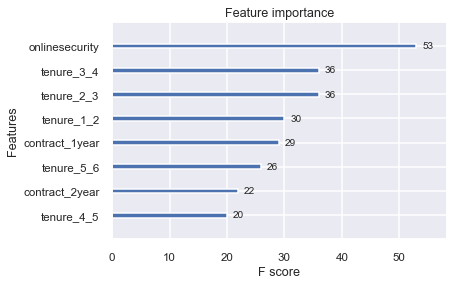

In [165]:
plot_importance(alg)

In [166]:
alg.get_booster().get_fscore()

{'tenure_2_3': 36,
 'tenure_4_5': 20,
 'onlinesecurity': 53,
 'tenure_1_2': 30,
 'contract_1year': 29,
 'tenure_3_4': 36,
 'contract_2year': 22,
 'tenure_5_6': 26}

### Random Forest

In [167]:
forest = RandomForestClassifier( class_weight='balanced',criterion='gini',n_estimators=200, max_depth= 10, min_samples_leaf= 5,random_state=23,)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [168]:
# Training accuracy score
forest.score(X_train, y_train)

0.728

In [169]:
# Test accuracy score
forest.score(X_test, y_test)

0.7412935323383084

In [170]:
y_test_predict= forest.predict(X_test)

In [171]:
metrics.f1_score(y_test,y_test_predict)

0.6278118609406953

### Bagging

In [172]:
bagging =  BaggingClassifier(n_estimators=200,random_state=23,bootstrap_features=True)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=True,
                  max_features=1.0, max_samples=1.0, n_estimators=200,
                  n_jobs=None, oob_score=False, random_state=23, verbose=0,
                  warm_start=False)

In [173]:
bagging.score(X_train, y_train)

0.7838222222222222

In [174]:
bagging.score(X_test, y_test)

0.7633262260127932

In [175]:
y_test_predict= bagging.predict(X_test)

In [176]:
metrics.f1_score(y_test,y_test_predict)

0.4962178517397882

In [177]:
X_train.shape

(5625, 8)

### GradientBoosting classifer

In [178]:
from sklearn.ensemble import GradientBoostingClassifier

In [179]:
#predictors = [x for x in train.columns if x not in [target, RowID]]
gbm = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9,
min_samples_split=1200, min_samples_leaf=60, subsample=0.85, random_state=10)

In [180]:
gbm.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=9,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=60, min_samples_split=1200,
                           min_weight_fraction_leaf=0.0, n_estimators=600,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=10, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [181]:
gbm.score(X_train, y_train)

0.7838222222222222

In [182]:
gbm.score(X_test, y_test)

0.7633262260127932

In [183]:
y_test_predict= gbm.predict(X_test)

In [184]:
metrics.f1_score(y_test,y_test_predict)

0.4962178517397882